In [2]:
from scipy.stats import ttest_ind
import helper 
import xarray as xr 
import numpy as np 
import cmaps as cmap 
import matplotlib.pyplot as plt
import scipy 
import warnings
import matplotlib.patheffects as pe
from matplotlib.colors import Normalize
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import matplotlib.patheffects as pe
warnings.filterwarnings("ignore")

def rePoPolar(dataset, name, offset):
    x = dataset.lon.values / 4
    y = dataset.lat.values / 4
    x, y = np.meshgrid(x, y)

    R = 6371.0
    cphi = np.cos(np.deg2rad(y))
    x = R * np.deg2rad(x) * cphi
    y = R * np.deg2rad(y)

    r = np.sqrt(x**2 + y**2)
    t = np.arctan2(y, x)

    rBins = np.linspace(np.nanmin(r), np.nanmax(r), 120)
    tBins = np.linspace(np.nanmin(t), np.nanmax(t), 360)

    for i in range(len(tBins)):
            tBins[i] = tBins[i] + offset
            while tBins[i] <= (-1 * np.pi):
                tBins[i] = tBins[i] + (2 * np.pi)
            while tBins[i] >= np.pi:
                tBins[i] = tBins[i] - (2 * np.pi)

    R, T = np.meshgrid(rBins, tBins)
    newX, newY = R * np.cos(T), R * np.sin(T)
    gridded_data = scipy.interpolate.griddata((x.flatten(), y.flatten()), dataset.values.flatten(), (newX.flatten(), newY.flatten()), method='nearest')

    polar = xr.Dataset(
        {
            name: (('r', 'theta'), gridded_data.reshape(R.shape).transpose())
        },
        coords={
            'r': rBins,
            'theta': tBins
        }
    )

    return polar


In [3]:
dataset = xr.open_dataset(r"C:\Users\deela\Downloads\TCRADAR_ERA5.nc")
print(dataset)
print(list(dataset.variables))

<xarray.Dataset> Size: 13GB
Dimensions:      (case: 1510, level: 17, lon: 121, lat: 121)
Coordinates:
  * level        (level) int16 34B 200 250 300 350 400 ... 800 850 900 950 1000
  * case         (case) int64 12kB 29 29 29 29 30 ... 3713 3715 3715 3715 3715
  * lon          (lon) int64 968B -60 -59 -58 -57 -56 -55 ... 55 56 57 58 59 60
  * lat          (lat) int64 968B -60 -59 -58 -57 -56 -55 ... 55 56 57 58 59 60
Data variables: (12/28)
    rlhum        (case, level, lon, lat) float32 2GB ...
    sphum        (case, level, lon, lat) float32 2GB ...
    u_data       (case, level, lon, lat) float32 2GB ...
    v_data       (case, level, lon, lat) float32 2GB ...
    temperature  (case, level, lon, lat) float32 2GB ...
    height       (case, level, lon, lat) float32 2GB ...
    ...           ...
    fdelta_vmax  (case) float32 6kB ...
    bdelta_vmax  (case) float32 6kB ...
    system_type  (case) <U2 12kB ...
    uspd         (case) float32 6kB ...
    vspd         (case) float32 6k

In [4]:
def process(data, ddir):
    dataList = []
    print(len(data.case))
    for x in range(len(data.case)):
        print(x)
        offset = np.deg2rad(360 - ddir.isel(case = x))
        try:
            temp = rePoPolar(data.isel(case = x), 'rh', offset = offset)
        except:
            temp = xr.Dataset(
                {
                    var: (temp[var].dims, np.full_like(temp[var], np.nan))
                    for var in temp.data_vars
                },
                coords=temp.coords,
                attrs=temp.attrs)

        dataList.append(temp)

    newTheta = np.linspace(-np.pi, np.pi, 360, endpoint=False)
    for x in range(len(dataList)):
        try:
            dataList[x] = dataList[x].interp(theta = newTheta)    
            dataList[x]['rh'].values = np.flip(dataList[x]['rh'].values, axis = 1)
        except:
            pass

    rh = xr.concat(dataList, dim = 'case')
    print(rh)  

    return rh, newTheta 

In [5]:
alignment = [225, 251, 252, 253, 254, 333, 334, 347, 374, 376, 377, 407, 408, 409, 410, 413, 414, 603, 604, 605, 672, 712, 719, 752, 765, 864, 878, 879, 939, 941, 957, 968, 969, 970, 971, 1057, 1073, 1101, 1128, 1131, 1148, 1177, 1178, 1179, 1180, 1191, 1192, 1220, 1221, 1222, 1223, 1224, 1226, 1227, 1228, 1302, 1379, 1380, 1391, 1405, 1406, 1445, 1446, 1447, 1448, 1453, 1471]
misalign = [148, 149, 223, 224, 339, 340, 341, 342, 343, 344, 382, 383, 384, 386, 400, 402, 423, 424, 425, 426, 427, 429, 430, 431, 545, 600, 601, 742, 744, 745, 747, 757, 760, 869, 898, 899, 918, 919, 930, 934, 935, 936, 1042, 1052, 1174, 1175, 1195, 1197, 1201, 1217, 1218, 1372, 1373, 1376, 1377, 1408, 1410, 1418, 1419]

In [6]:
def labels(ax, flag = False):
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    if flag == False:
        ax.text(1 * np.pi / 4, 1000, 'Downshear\nRight', size = 12, color = 'black', horizontalalignment = 'center', fontfamily = 'Courier New', fontweight = 'bold', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")], verticalalignment = 'center')
        ax.text(3 * np.pi / 4, 1000, 'Upshear\nRight', size = 12, color = 'black', horizontalalignment = 'center', fontfamily = 'Courier New', fontweight = 'bold', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")], verticalalignment = 'center')
        ax.text(5 * np.pi / 4, 1000, 'Upshear\nLeft', size = 12, color = 'black', horizontalalignment = 'center', fontfamily = 'Courier New', fontweight = 'bold', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")], verticalalignment = 'center')
        ax.text(7 * np.pi / 4, 1000, 'Downshear\nLeft', size = 12, color = 'black', horizontalalignment = 'center', fontfamily = 'Courier New', fontweight = 'bold', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")], verticalalignment = 'center')
        
        ax.annotate('', xy=(0, 500), xytext=(np.pi, 500),
                arrowprops=dict(facecolor='black', edgecolor='black', width=1, headwidth=8, headlength=10, path_effects=[pe.withStroke(linewidth=2.25, foreground="white")]))

    ax.set_yticklabels(['', '200km', '', '600km', '', '1000km', '', ''], fontfamily = 'Courier New', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")])
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'], fontfamily = 'Courier New', path_effects=[pe.withStroke(linewidth=2.25, foreground="white")])


In [7]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def relh():
    newcmp = LinearSegmentedColormap.from_list("",[
    (0/100, "#000000"),
    (15/100, "#2e2e2e"),
    (25/100, "#4d2417"),
    (35/100, "#6e3e04"),
    (45/100, "#c7ad8d"),

    (50/100, "#FFFFFF"),
    
    (55/100, "#5c9d8d"),
    (65/100, "#1f5725"),
    (75/100, "#1f2f40"),
    (85/100, "#100729"),
    (100/100, "#385484")])

    return newcmp

In [ ]:
data = dataset['rlhum'].sel(level = slice(400, 700)).mean('level')

ddir = dataset['shear_dir']
var = 'Relative Humidity'
varShort = 'rh'
height = f'400-700mb'

rh, newTheta = process(data, ddir)

t = f'{height} {var}'

refl1 = rh[varShort].sel(case = alignment, r = slice(0, 1500)).mean('case')
refl2 = rh[varShort].sel(case = misalign, r = slice(0, 1500)).mean('case')
refl = rh[varShort].sel(r = slice(0, 1500)).mean('case')
data = refl1 - refl2

fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(18, 15))
axes[0, 0].pcolormesh(newTheta, refl1.r, refl1, cmap = relh(), vmin = 0, vmax = 100)
labels(axes[0, 0])

c = axes[0, 1].pcolormesh(newTheta, refl2.r, refl2, cmap = relh(), vmin = 0, vmax = 100)
labels(axes[0, 1])

ca = axes[1, 0].pcolormesh(newTheta, refl2.r, data, cmap = cmap.tempAnoms3(), vmin = -20, vmax = 20)
labels(axes[1, 0])

c = axes[1, 1].pcolormesh(newTheta, refl.r, refl, cmap = relh(), vmin = 0, vmax = 100)
labels(axes[1, 1])

cbar = fig.colorbar(c, ax=axes, orientation='vertical', aspect=50, pad=0.04)
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)

pos = axes[1, 0].get_position()

cbar_ax = fig.add_axes([
    pos.x0,            
    pos.y0 - 0.025,     
    pos.width,         
    0.005               
])

cbar = fig.colorbar(ca, cax=cbar_ax, orientation='horizontal')

fig.suptitle(f'TC-RADAR: Shear-Relative Composite {t}                               \n\n' , fontweight='bold', fontsize=10, y = 0.93)

axes[0, 0].set_title(f'Aligning (Mean RH < 500km: {str(round(np.nanmean(refl1.sel(r = slice(0, 500))), 1))}%)', fontsize=9)
axes[0, 1].set_title(f'Non-Aligning (Mean RH < 500km: {str(round(np.nanmean(refl2.sel(r = slice(0, 500))), 1))}%)', fontsize=9)
axes[1, 0].set_title(f'Difference (Mean RH < 500km: {str(round(np.nanmean(data.sel(r = slice(0, 500))), 1))}%)', fontsize=9)
axes[1, 1].set_title(f'All Cases (Mean RH < 500km: {str(round(np.nanmean(refl.sel(r = slice(0, 500))), 1))}%)', fontsize=9)

plt.savefig(r"C:\Users\deela\Downloads\tilt400_700rh.png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [7]:
thetaes = helper.thetaes(dataset['temperature'], dataset['level'], 1000)#, dataset['sphum'])

In [15]:
data = 1005 * (np.log(thetaes.sel(level = slice(700, 850))).mean('level') - np.log(thetaes.sel(level = slice(400, 550))).mean('level'))

ddir = dataset['shear_dir']
var = 'Instability Index'
varShort = 'rh'
height = f'850-700 - 550-400'

rh, newTheta = process(data, ddir)

t = f'{height} {var}'

1510
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

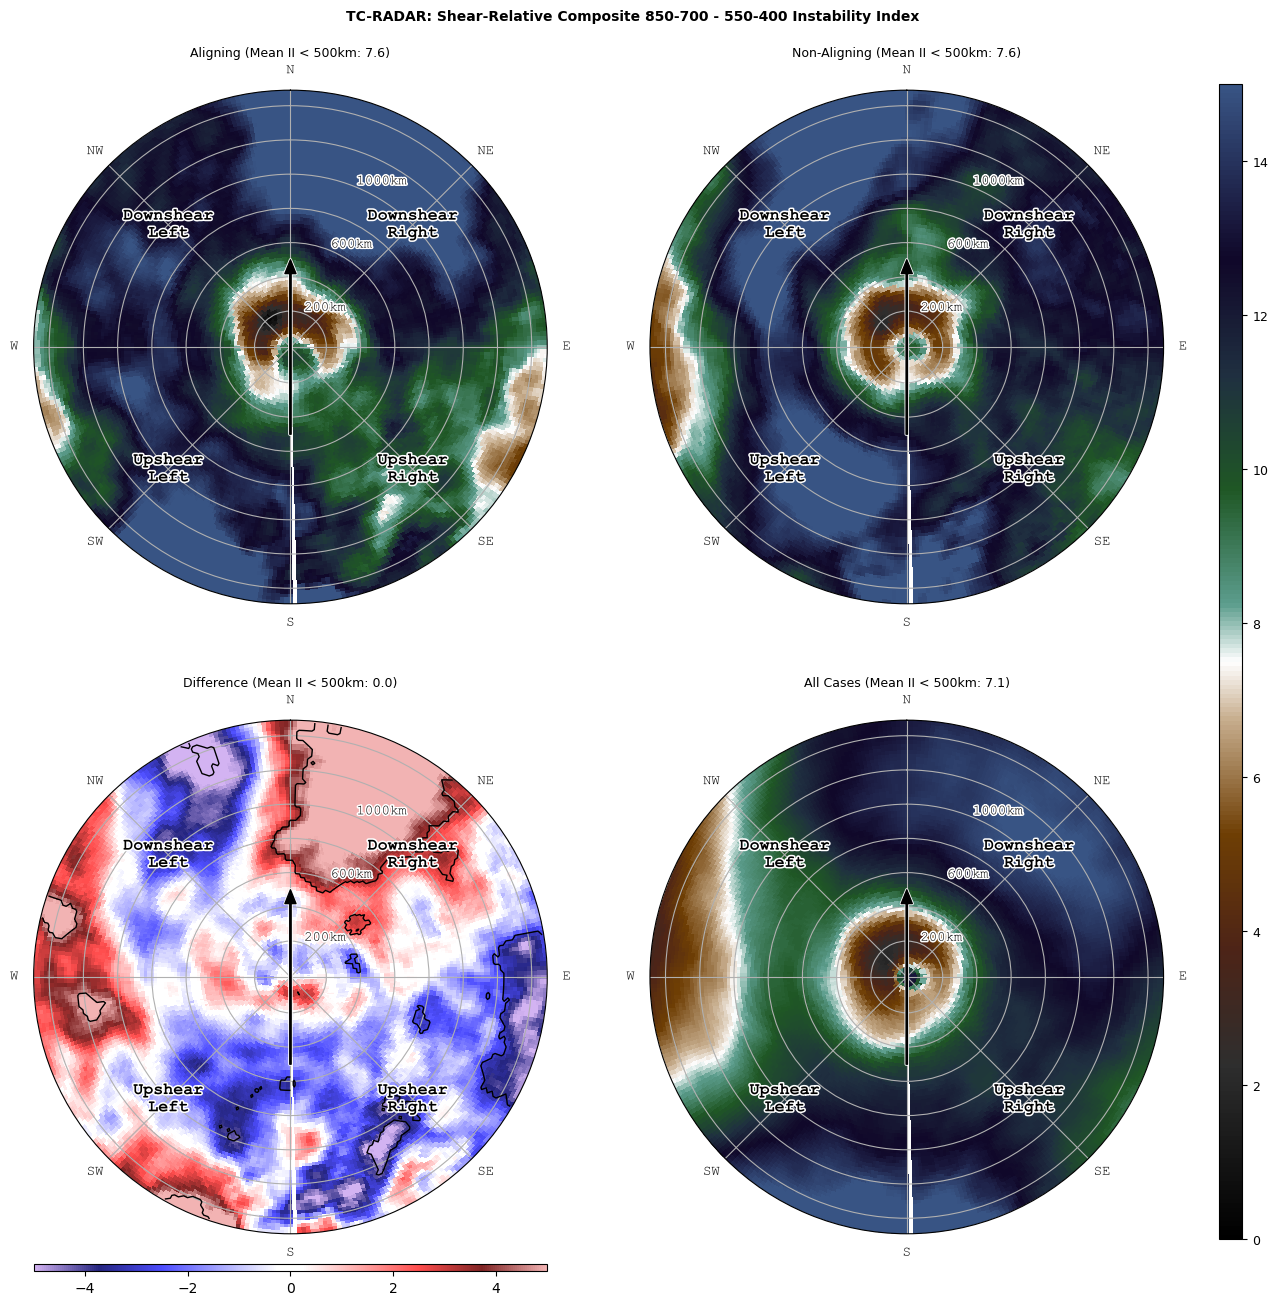

In [19]:
refl1 = rh[varShort].sel(case = alignment, r = slice(0, 1500)).mean('case')
refl2 = rh[varShort].sel(case = misalign, r = slice(0, 1500)).mean('case')
refl = rh[varShort].sel(r = slice(0, 1500)).mean('case')
data = refl1 - refl2
tstat, pval = ttest_ind(rh[varShort].sel(case = alignment, r = slice(0, 1500)), rh[varShort].sel(case = misalign, r = slice(0, 1500)), axis = 0, equal_var=False, nan_policy='omit')
sig_mask = pval < 0.05

fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(18, 15))
axes[0, 0].pcolormesh(newTheta, refl1.r, refl1, cmap = relh(), vmin = 0, vmax = 15)
labels(axes[0, 0])

c = axes[0, 1].pcolormesh(newTheta, refl2.r, refl2, cmap = relh(), vmin = 0, vmax = 15)
labels(axes[0, 1])

ca = axes[1, 0].pcolormesh(newTheta, refl2.r, data, cmap = cmap.tempAnoms3(), vmin = -5, vmax = 5)
axes[1, 0].contour(newTheta, refl2.r, sig_mask, levels=[0.5], colors='black', linewidths=1)
labels(axes[1, 0])

c = axes[1, 1].pcolormesh(newTheta, refl.r, refl, cmap = relh(), vmin = 0, vmax = 15)
labels(axes[1, 1])

cbar = fig.colorbar(c, ax=axes, orientation='vertical', aspect=50, pad=0.04)
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)

pos = axes[1, 0].get_position()

cbar_ax = fig.add_axes([
    pos.x0,            
    pos.y0 - 0.025,     
    pos.width,         
    0.005               
])

cbar = fig.colorbar(ca, cax=cbar_ax, orientation='horizontal')

fig.suptitle(f'TC-RADAR: Shear-Relative Composite {t}                               \n\n' , fontweight='bold', fontsize=10, y = 0.93)

axes[0, 0].set_title(f'Aligning (Mean II < 500km: {str(round(np.nanmean(refl1.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[0, 1].set_title(f'Non-Aligning (Mean II < 500km: {str(round(np.nanmean(refl2.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[1, 0].set_title(f'Difference (Mean II < 500km: {str(round(np.nanmean(data.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[1, 1].set_title(f'All Cases (Mean II < 500km: {str(round(np.nanmean(refl.sel(r = slice(0, 500))), 1))})', fontsize=9)

plt.savefig(r"C:\Users\deela\Downloads\tilt" + t + ".png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
hgt = 700
data = helper.thetae(dataset['temperature'], dataset['level'], 1000, dataset['sphum'])
data = data.sel(level = slice(600, 850)).mean('level')

ddir = dataset['shear_dir']
var = 'Theta-E'
varShort = 'rh'
height = f'600 to 850mb'

rh, newTheta = process(data, ddir)

t = f'{height} {var}'

In [ ]:
refl1 = rh[varShort].sel(case = alignment, r = slice(0, 1500)).mean('case')
refl2 = rh[varShort].sel(case = misalign, r = slice(0, 1500)).mean('case')
refl = rh[varShort].sel(r = slice(0, 1500)).mean('case')
data = refl1 - refl2
tstat, pval = ttest_ind(rh[varShort].sel(case = alignment, r = slice(0, 1500)), rh[varShort].sel(case = misalign, r = slice(0, 1500)), axis = 0, equal_var=False, nan_policy='omit')
sig_mask = pval < 0.05

fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(18, 15))
axes[0, 0].pcolormesh(newTheta, refl1.r, refl1, cmap = relh(), vmin = 325, vmax = 345)
labels(axes[0, 0])

c = axes[0, 1].pcolormesh(newTheta, refl2.r, refl2, cmap = relh(), vmin = 325, vmax = 345)
labels(axes[0, 1])

ca = axes[1, 0].pcolormesh(newTheta, refl2.r, data, cmap = cmap.tempAnoms3(), vmin = -5, vmax = 5)
axes[1, 0].contour(newTheta, refl2.r, sig_mask, levels=[0.5], colors='black', linewidths=1)
labels(axes[1, 0])

c = axes[1, 1].pcolormesh(newTheta, refl.r, refl, cmap = relh(), vmin = 325, vmax = 345)
labels(axes[1, 1])

cbar = fig.colorbar(c, ax=axes, orientation='vertical', aspect=50, pad=0.04)
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)

pos = axes[1, 0].get_position()

cbar_ax = fig.add_axes([
    pos.x0,            
    pos.y0 - 0.025,     
    pos.width,         
    0.005               
])

cbar = fig.colorbar(ca, cax=cbar_ax, orientation='horizontal')

fig.suptitle(f'TC-RADAR: Shear-Relative Composite {t}                               \n\n' , fontweight='bold', fontsize=10, y = 0.93)

axes[0, 0].set_title(f'Aligning (Mean Theta-E < 500km: {str(round(np.nanmean(refl1.sel(r = slice(0, 500))), 1))}K)', fontsize=9)
axes[0, 1].set_title(f'Non-Aligning (Mean Theta-E < 500km: {str(round(np.nanmean(refl2.sel(r = slice(0, 500))), 1))}K)', fontsize=9)
axes[1, 0].set_title(f'Difference (Mean Theta-E < 500km: {str(round(np.nanmean(data.sel(r = slice(0, 500))), 1))}K)', fontsize=9)
axes[1, 1].set_title(f'All Cases (Mean Theta-E < 500km: {str(round(np.nanmean(refl.sel(r = slice(0, 500))), 1))}K)', fontsize=9)

plt.savefig(r"C:\Users\deela\Downloads\tilt" + t + ".png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
data = dataset['u_data'].sel(level = 200) - dataset['u_data'].sel(level = 850)
data = data * 1.94384

ddir = dataset['shear_dir']
var = 'Wind Shear'
varShort = 'rh'
height = f'Deep-Layer Zonal'

rh, newTheta = process(data, ddir)

t = f'{height} {var}'

In [ ]:
refl1 = rh[varShort].sel(case = alignment, r = slice(0, 1500)).mean('case')
refl2 = rh[varShort].sel(case = misalign, r = slice(0, 1500)).mean('case')
refl = rh[varShort].sel(r = slice(0, 1500)).mean('case')
data = refl1 - refl2

fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(18, 15))
axes[0, 0].pcolormesh(newTheta, refl1.r, refl1, cmap = cmap.tempAnoms3(), vmin = -40, vmax = 40)
labels(axes[0, 0])

c = axes[0, 1].pcolormesh(newTheta, refl2.r, refl2, cmap = cmap.tempAnoms3(), vmin = -40, vmax = 40)
labels(axes[0, 1])

ca = axes[1, 0].pcolormesh(newTheta, refl2.r, data, cmap = cmap.tempAnoms3(), vmin = -10, vmax = 10)
labels(axes[1, 0])

c = axes[1, 1].pcolormesh(newTheta, refl.r, refl, cmap = cmap.tempAnoms3(), vmin = -40, vmax = 40)
labels(axes[1, 1])

cbar = fig.colorbar(c, ax=axes, orientation='vertical', aspect=50, pad=0.04)
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)

pos = axes[1, 0].get_position()

cbar_ax = fig.add_axes([
    pos.x0,            
    pos.y0 - 0.025,     
    pos.width,         
    0.005               
])

cbar = fig.colorbar(ca, cax=cbar_ax, orientation='horizontal')

fig.suptitle(f'TC-RADAR: Shear-Relative Composite {t}                               \n\n' , fontweight='bold', fontsize=10, y = 0.93)

axes[0, 0].set_title(f'Aligning (Mean Shear < 500km: {str(round(np.nanmean(refl1.sel(r = slice(0, 500))), 1))}kt)', fontsize=9)
axes[0, 1].set_title(f'Non-Aligning (Mean Shear < 500km: {str(round(np.nanmean(refl2.sel(r = slice(0, 500))), 1))}kt)', fontsize=9)
axes[1, 0].set_title(f'Difference (Mean Shear < 500km: {str(round(np.nanmean(data.sel(r = slice(0, 500))), 1))}kt)', fontsize=9)
axes[1, 1].set_title(f'All Cases (Mean Shear < 500km: {str(round(np.nanmean(refl.sel(r = slice(0, 500))), 1))}kt)', fontsize=9)

plt.savefig(r"C:\Users\deela\Downloads\tilt200850ushear.png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
data = dataset['v_data'].sel(level = 200) - dataset['v_data'].sel(level = 850)
data = data * 1.94384

ddir = dataset['shear_dir']
var = 'Wind Shear'
varShort = 'rh'
height = f'Deep-Layer Meridional'

rh, newTheta = process(data, ddir)

t = f'{height} {var}'

In [ ]:
refl1 = rh[varShort].sel(case = alignment, r = slice(0, 1500)).mean('case')
refl2 = rh[varShort].sel(case = misalign, r = slice(0, 1500)).mean('case')
refl = rh[varShort].sel(r = slice(0, 1500)).mean('case')
data = refl1 - refl2

fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(18, 15))
axes[0, 0].pcolormesh(newTheta, refl1.r, refl1, cmap = cmap.tempAnoms3(), vmin = -40, vmax = 40)
labels(axes[0, 0])

c = axes[0, 1].pcolormesh(newTheta, refl2.r, refl2, cmap = cmap.tempAnoms3(), vmin = -40, vmax = 40)
labels(axes[0, 1])

ca = axes[1, 0].pcolormesh(newTheta, refl2.r, data, cmap = cmap.tempAnoms3(), vmin = -10, vmax = 10)
labels(axes[1, 0])

c = axes[1, 1].pcolormesh(newTheta, refl.r, refl, cmap = cmap.tempAnoms3(), vmin = -40, vmax = 40)
labels(axes[1, 1])

cbar = fig.colorbar(c, ax=axes, orientation='vertical', aspect=50, pad=0.04)
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)

pos = axes[1, 0].get_position()

cbar_ax = fig.add_axes([
    pos.x0,            
    pos.y0 - 0.025,     
    pos.width,         
    0.005               
])

cbar = fig.colorbar(ca, cax=cbar_ax, orientation='horizontal')

fig.suptitle(f'TC-RADAR: Shear-Relative Composite {t}                               \n\n' , fontweight='bold', fontsize=10, y = 0.93)

axes[0, 0].set_title(f'Aligning (Mean Shear < 500km: {str(round(np.nanmean(refl1.sel(r = slice(0, 500))), 1))}kt)', fontsize=9)
axes[0, 1].set_title(f'Non-Aligning (Mean Shear < 500km: {str(round(np.nanmean(refl2.sel(r = slice(0, 500))), 1))}kt)', fontsize=9)
axes[1, 0].set_title(f'Difference (Mean Shear < 500km: {str(round(np.nanmean(data.sel(r = slice(0, 500))), 1))}kt)', fontsize=9)
axes[1, 1].set_title(f'All Cases (Mean Shear < 500km: {str(round(np.nanmean(refl.sel(r = slice(0, 500))), 1))}kt)', fontsize=9)

plt.savefig(r"C:\Users\deela\Downloads\tilt200850vshear.png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
u = dataset['u_data'].sel(level = 200) - dataset['u_data'].sel(level = 850)
v = dataset['v_data'].sel(level = 200) - dataset['v_data'].sel(level = 850)
data = (u**2 + v**2)**0.5
data = data * 1.94384

ddir = dataset['shear_dir']
var = 'Wind Shear'
varShort = 'rh'
height = f'Deep-Layer Magnitude of'

rh, newTheta = process(data, ddir)

t = f'{height} {var}'

In [ ]:
refl1 = rh[varShort].sel(case = alignment, r = slice(0, 1500)).mean('case')
refl2 = rh[varShort].sel(case = misalign, r = slice(0, 1500)).mean('case')
refl = rh[varShort].sel(r = slice(0, 1500)).mean('case')
data = refl1 - refl2

fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(18, 15))
axes[0, 0].pcolormesh(newTheta, refl1.r, refl1, cmap = cmap.probs2(), vmin = 10, vmax = 50)
labels(axes[0, 0])

c = axes[0, 1].pcolormesh(newTheta, refl2.r, refl2, cmap = cmap.probs2(), vmin = 10, vmax = 50)
labels(axes[0, 1])

ca = axes[1, 0].pcolormesh(newTheta, refl2.r, data, cmap = cmap.tempAnoms3(), vmin = -10, vmax = 10)
labels(axes[1, 0])

c = axes[1, 1].pcolormesh(newTheta, refl.r, refl, cmap = cmap.probs2(), vmin = 10, vmax = 50)
labels(axes[1, 1])

cbar = fig.colorbar(c, ax=axes, orientation='vertical', aspect=50, pad=0.04)
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)

pos = axes[1, 0].get_position()

cbar_ax = fig.add_axes([
    pos.x0,            
    pos.y0 - 0.025,     
    pos.width,         
    0.005               
])

cbar = fig.colorbar(ca, cax=cbar_ax, orientation='horizontal')

fig.suptitle(f'TC-RADAR: Shear-Relative Composite {t}                               \n\n' , fontweight='bold', fontsize=10, y = 0.93)

axes[0, 0].set_title(f'Aligning (Mean Shear < 500km: {str(round(np.nanmean(refl1.sel(r = slice(0, 500))), 1))}kt)', fontsize=9)
axes[0, 1].set_title(f'Non-Aligning (Mean Shear < 500km: {str(round(np.nanmean(refl2.sel(r = slice(0, 500))), 1))}kt)', fontsize=9)
axes[1, 0].set_title(f'Difference (Mean Shear < 500km: {str(round(np.nanmean(data.sel(r = slice(0, 500))), 1))}kt)', fontsize=9)
axes[1, 1].set_title(f'All Cases (Mean Shear < 500km: {str(round(np.nanmean(refl.sel(r = slice(0, 500))), 1))}kt)', fontsize=9)

plt.savefig(r"C:\Users\deela\Downloads\tilt200850shear.png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
hgt = 850
data = dataset['vorticity']
data = data.sel(level = hgt)

ddir = dataset['shear_dir']
var = 'Vorticity'
varShort = 'rh'
height = f'{hgt}mb'

rh, newTheta = process(data, ddir)

t = f'{height} {var}'

In [ ]:
refl1 = rh[varShort].sel(case = alignment, r = slice(0, 1500)).mean('case')
refl2 = rh[varShort].sel(case = misalign, r = slice(0, 1500)).mean('case')
refl = rh[varShort].sel(r = slice(0, 1500)).mean('case')
data = refl1 - refl2

fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(18, 15))
axes[0, 0].pcolormesh(newTheta, refl1.r, refl1, cmap = cmap.tempAnoms3(), vmin = -1e-4, vmax = 1e-4)
labels(axes[0, 0])

c = axes[0, 1].pcolormesh(newTheta, refl2.r, refl2, cmap = cmap.tempAnoms3(), vmin = -1e-4, vmax = 1e-4)
labels(axes[0, 1])

ca = axes[1, 0].pcolormesh(newTheta, refl2.r, data, cmap = cmap.tempAnoms3(), vmin = -1e-4, vmax = 1e-4)
labels(axes[1, 0])

c = axes[1, 1].pcolormesh(newTheta, refl.r, refl, cmap = cmap.tempAnoms3(), vmin = -1e-4, vmax = 1e-4)
labels(axes[1, 1])

cbar = fig.colorbar(c, ax=axes, orientation='vertical', aspect=50, pad=0.04)
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)

pos = axes[1, 0].get_position()

cbar_ax = fig.add_axes([
    pos.x0,            
    pos.y0 - 0.025,     
    pos.width,         
    0.005               
])

cbar = fig.colorbar(ca, cax=cbar_ax, orientation='horizontal')

fig.suptitle(f'TC-RADAR: Shear-Relative Composite {t}                               \n\n' , fontweight='bold', fontsize=10, y = 0.93)

axes[0, 0].set_title(f'Aligning (Mean Vort < 500km: {str(round(np.nanmean(refl1.sel(r = slice(0, 500))), 1))} s^-1)', fontsize=9)
axes[0, 1].set_title(f'Non-Aligning (Mean Vort < 500km: {str(round(np.nanmean(refl2.sel(r = slice(0, 500))), 1))} s^-1)', fontsize=9)
axes[1, 0].set_title(f'Difference (Mean Vort < 500km: {str(round(np.nanmean(data.sel(r = slice(0, 500))), 1))} s^-1)', fontsize=9)
axes[1, 1].set_title(f'All Cases (Mean Vort < 500km: {str(round(np.nanmean(refl.sel(r = slice(0, 500))), 1))} s^-1)', fontsize=9)

plt.savefig(r"C:\Users\deela\Downloads\tilt" + t + ".png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
hgt = 200
data = dataset['height']
data = data.sel(level = hgt)

ddir = dataset['shear_dir']
var = 'Geopotential Height'
varShort = 'rh'
height = f'{hgt}mb'

rh, newTheta = process(data, ddir)

t = f'{height} {var}'

In [ ]:
refl1 = rh[varShort].sel(case = alignment, r = slice(0, 1500)).mean('case')
refl2 = rh[varShort].sel(case = misalign, r = slice(0, 1500)).mean('case')
refl = rh[varShort].sel(r = slice(0, 1500)).mean('case')
data = refl1 - refl2
tstat, pval = ttest_ind(rh[varShort].sel(case = alignment, r = slice(0, 1500)), rh[varShort].sel(case = misalign, r = slice(0, 1500)), axis = 0, equal_var=False, nan_policy='omit')
sig_mask = pval < 0.05

fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(18, 15))
axes[0, 0].pcolormesh(newTheta, refl1.r, refl1, cmap = cmap.probs4(), vmin = 12400, vmax = 12475)
labels(axes[0, 0])

c = axes[0, 1].pcolormesh(newTheta, refl2.r, refl2, cmap = cmap.probs4(), vmin = 12400, vmax = 12475)
labels(axes[0, 1])

ca = axes[1, 0].pcolormesh(newTheta, refl2.r, data, cmap = cmap.tempAnoms3(), vmin = -30, vmax = 30)
axes[1, 0].contour(newTheta, refl2.r, sig_mask, levels=[0.5], colors='black', linewidths=1)
labels(axes[1, 0])

c = axes[1, 1].pcolormesh(newTheta, refl.r, refl, cmap = cmap.probs4(), vmin = 12400, vmax = 12475)
labels(axes[1, 1])

cbar = fig.colorbar(c, ax=axes, orientation='vertical', aspect=50, pad=0.04)
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)

pos = axes[1, 0].get_position()

cbar_ax = fig.add_axes([
    pos.x0,            
    pos.y0 - 0.025,     
    pos.width,         
    0.005               
])

cbar = fig.colorbar(ca, cax=cbar_ax, orientation='horizontal')

fig.suptitle(f'TC-RADAR: Shear-Relative Composite {t}                               \n\n' , fontweight='bold', fontsize=10, y = 0.93)

axes[0, 0].set_title(f'Aligning (Mean Height < 500km: {str(round(np.nanmean(refl1.sel(r = slice(0, 500))), 1))}m)', fontsize=9)
axes[0, 1].set_title(f'Non-Aligning (Mean Height < 500km: {str(round(np.nanmean(refl2.sel(r = slice(0, 500))), 1))}m)', fontsize=9)
axes[1, 0].set_title(f'Difference (Mean Height < 500km: {str(round(np.nanmean(data.sel(r = slice(0, 500))), 1))}m)', fontsize=9)
axes[1, 1].set_title(f'All Cases (Mean Height < 500km: {str(round(np.nanmean(refl.sel(r = slice(0, 500))), 1))}m)', fontsize=9)

plt.savefig(r"C:\Users\deela\Downloads\tilt" + t + ".png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
hgt = 850
data = dataset['sphum']
data = data.sel(level = hgt)

ddir = dataset['shear_dir']
var = 'Specific Humidity'
varShort = 'rh'
height = f'{hgt}mb'

rh, newTheta = process(data, ddir)

t = f'{height} {var}'

In [ ]:
refl1 = rh[varShort].sel(case = alignment, r = slice(0, 1500)).mean('case')
refl2 = rh[varShort].sel(case = misalign, r = slice(0, 1500)).mean('case')
refl = rh[varShort].sel(r = slice(0, 1500)).mean('case')
data = refl1 - refl2
tstat, pval = ttest_ind(rh[varShort].sel(case = alignment, r = slice(0, 1500)), rh[varShort].sel(case = misalign, r = slice(0, 1500)), axis = 0, equal_var=False, nan_policy='omit')
sig_mask = pval < 0.05

fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(18, 15))
axes[0, 0].pcolormesh(newTheta, refl1.r, refl1, cmap = cmap.probs4(), vmin = 0.0075, vmax = 0.015)
labels(axes[0, 0])

c = axes[0, 1].pcolormesh(newTheta, refl2.r, refl2, cmap = cmap.probs4(), vmin = 0.0075, vmax = 0.015)
labels(axes[0, 1])

ca = axes[1, 0].pcolormesh(newTheta, refl2.r, data, cmap = cmap.tempAnoms3(), vmin = -.0025, vmax = .0025)
axes[1, 0].contour(newTheta, refl2.r, sig_mask, levels=[0.5], colors='black', linewidths=1)
labels(axes[1, 0])

c = axes[1, 1].pcolormesh(newTheta, refl.r, refl, cmap = cmap.probs4(), vmin = 0.0075, vmax = 0.015)
labels(axes[1, 1])

cbar = fig.colorbar(c, ax=axes, orientation='vertical', aspect=50, pad=0.04)
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)

pos = axes[1, 0].get_position()

cbar_ax = fig.add_axes([
    pos.x0,            
    pos.y0 - 0.025,     
    pos.width,         
    0.005               
])

cbar = fig.colorbar(ca, cax=cbar_ax, orientation='horizontal')

fig.suptitle(f'TC-RADAR: Shear-Relative Composite {t}                               \n\n' , fontweight='bold', fontsize=10, y = 0.93)

axes[0, 0].set_title(f'Aligning (Mean SHUM < 500km: {str(round(np.nanmean(refl1.sel(r = slice(0, 500))), 1))}kg/kg)', fontsize=9)
axes[0, 1].set_title(f'Non-Aligning (Mean SHUM < 500km: {str(round(np.nanmean(refl2.sel(r = slice(0, 500))), 1))}kg/kg)', fontsize=9)
axes[1, 0].set_title(f'Difference (Mean SHUM < 500km: {str(round(np.nanmean(data.sel(r = slice(0, 500))), 1))}kg/kg)', fontsize=9)
axes[1, 1].set_title(f'All Cases (Mean SHUM < 500km: {str(round(np.nanmean(refl.sel(r = slice(0, 500))), 1))}kg/kg)', fontsize=9)

plt.savefig(r"C:\Users\deela\Downloads\tilt" + t + ".png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
hgt = 850
data = dataset['temperature']
data = data.sel(level = hgt)

ddir = dataset['shear_dir']
var = 'Temperature'
varShort = 'rh'
height = f'{hgt}mb'

rh, newTheta = process(data, ddir)

t = f'{height} {var}'

In [ ]:
refl1 = rh[varShort].sel(case = alignment, r = slice(0, 1500)).mean('case')
refl2 = rh[varShort].sel(case = misalign, r = slice(0, 1500)).mean('case')
refl = rh[varShort].sel(r = slice(0, 1500)).mean('case')
data = refl1 - refl2
tstat, pval = ttest_ind(rh[varShort].sel(case = alignment, r = slice(0, 1500)), rh[varShort].sel(case = misalign, r = slice(0, 1500)), axis = 0, equal_var=False, nan_policy='omit')
sig_mask = pval < 0.05

fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(18, 15))
axes[0, 0].pcolormesh(newTheta, refl1.r, refl1, cmap = cmap.probs4(), vmin = 289, vmax = 293)
labels(axes[0, 0])

c = axes[0, 1].pcolormesh(newTheta, refl2.r, refl2, cmap = cmap.probs4(), vmin = 289, vmax = 293)
labels(axes[0, 1])

ca = axes[1, 0].pcolormesh(newTheta, refl2.r, data, cmap = cmap.tempAnoms3(), vmin = -2, vmax = 2)
axes[1, 0].contour(newTheta, refl2.r, sig_mask, levels=[0.5], colors='black', linewidths=1)
labels(axes[1, 0])

c = axes[1, 1].pcolormesh(newTheta, refl.r, refl, cmap = cmap.probs4(), vmin = 289, vmax = 293)
labels(axes[1, 1])

cbar = fig.colorbar(c, ax=axes, orientation='vertical', aspect=50, pad=0.04)
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)

pos = axes[1, 0].get_position()

cbar_ax = fig.add_axes([
    pos.x0,            
    pos.y0 - 0.025,     
    pos.width,         
    0.005               
])

cbar = fig.colorbar(ca, cax=cbar_ax, orientation='horizontal')

fig.suptitle(f'TC-RADAR: Shear-Relative Composite {t}                               \n\n' , fontweight='bold', fontsize=10, y = 0.93)

axes[0, 0].set_title(f'Aligning (Mean Temp < 500km: {str(round(np.nanmean(refl1.sel(r = slice(0, 500))), 1))}K)', fontsize=9)
axes[0, 1].set_title(f'Non-Aligning (Mean Temp < 500km: {str(round(np.nanmean(refl2.sel(r = slice(0, 500))), 1))}K)', fontsize=9)
axes[1, 0].set_title(f'Difference (Mean Temp < 500km: {str(round(np.nanmean(data.sel(r = slice(0, 500))), 1))}K)', fontsize=9)
axes[1, 1].set_title(f'All Cases (Mean Temp < 500km: {str(round(np.nanmean(refl.sel(r = slice(0, 500))), 1))}K)', fontsize=9)

plt.savefig(r"C:\Users\deela\Downloads\tilt" + t + ".png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
from helper import helicity, helicityv2

# def computeHelicity(ds):
#     # Subset levels for the profile integral and for the motion layer
#     prof = ds.sel(level=slice(200, 850))  # (level, lat, lon)
#     uM   = ds['u_data'].sel(level=slice(500, 850)).mean('level').astype('float32')  # (lat, lon)
#     vM   = ds['v_data'].sel(level=slice(500, 850)).mean('level').astype('float32')  # (lat, lon)

#     # Freeze the vertical coordinate as a plain 1D numpy array (helper expects arrays)
#     levels = prof['level'].values  # 1D

#     # Wrap your helper so apply_ufunc can broadcast across (lat, lon)
#     def _helicity_cell(uw_prof, vw_prof, u_motion, v_motion):
#         # uw_prof, vw_prof are 1D over level; u_motion, v_motion are scalars at (lat,lon)
#         if np.isnan(uw_prof).any() or np.isnan(vw_prof).any():
#             return np.nan
#         return helper.helicity(levels, uw_prof.astype(np.float32), vw_prof.astype(np.float32),
#                                np.float32(u_motion), np.float32(v_motion))

#     srh = xr.apply_ufunc(
#         _helicity_cell,
#         prof['u_data'],               # (level, lat, lon)
#         prof['v_data'],               # (level, lat, lon)
#         uM,                           # (lat, lon)
#         vM,                           # (lat, lon)
#         input_core_dims=[['level'], ['level'], [], []],
#         output_dtypes=[np.float32],
#         vectorize=True,
#         dask='parallelized'
#     )

#     # Ensure standard dims order (lat, lon)
#     dims = [d for d in ['case', 'lon', 'lat'] if d in srh.dims]
#     srh = srh.transpose(*dims)
#     srh.name = 'srh'
#     return srh

def computeHelicityv2(dataset, top = 200):
    data = dataset.sel(level = slice(top, 850))
    umotion = dataset['u_data'].sel(level = slice(500, 850)).mean(['level']).squeeze().astype('float32')
    vmotion = dataset['v_data'].sel(level = slice(500, 850)).mean(['level']).squeeze().astype('float32')

    uM = umotion#.sel(x = dataset.x[x], y = dataset.y[y]).values
    vM = vmotion#.sel(x = dataset.x[x], y = dataset.y[y]).values
    uwnd = data['u_data']#.sel(x = dataset.x[x], y = dataset.y[y]).astype('float32').squeeze().values
    vwnd = data['v_data']#.sel(x = dataset.x[x], y = dataset.y[y]).astype('float32').squeeze().values
    
    temp = helicityv2(uwnd, vwnd, uM, vM)

    return temp.squeeze(), umotion, vmotion

In [ ]:
ddir = dataset['shear_dir']
var = 'Storm-Relative Helicity'
varShort = 'rh'
height = f'500-850mb'
t = f'{height} {var}'

temp = dataset['temperature'].sel(level = 850)

srh, umotion, vmotion = computeHelicityv2(dataset.compute(), 500)
print(srh)
print('SRH computed!')

rh, newTheta = process(srh, ddir)

In [ ]:
var = 'Storm-Relative Helicity'
varShort = 'rh'
height = f'500 to 850mb'
t = f'{height} {var}'

In [ ]:
refl1 = rh[varShort].sel(case = alignment, r = slice(0, 1500)).mean('case')
refl2 = rh[varShort].sel(case = misalign, r = slice(0, 1500)).mean('case')
refl = rh[varShort].sel(r = slice(0, 1500)).mean('case')
data = refl1 - refl2
tstat, pval = ttest_ind(rh[varShort].sel(case = alignment, r = slice(0, 1500)), rh[varShort].sel(case = misalign, r = slice(0, 1500)), axis = 0, equal_var=False, nan_policy='omit')
sig_mask = pval < 0.05

fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(18, 15))
axes[0, 0].pcolormesh(newTheta, refl1.r, refl1, cmap = cmap.tempAnoms3(), vmin = -100, vmax = 100)
labels(axes[0, 0])

c = axes[0, 1].pcolormesh(newTheta, refl2.r, refl2, cmap = cmap.tempAnoms3(), vmin = -100, vmax = 100)
labels(axes[0, 1])

ca = axes[1, 0].pcolormesh(newTheta, refl2.r, data, cmap = cmap.tempAnoms3(), vmin = -200, vmax = 200)
axes[1, 0].contour(newTheta, refl2.r, sig_mask, levels=[0.5], colors='black', linewidths=1)
labels(axes[1, 0])

c = axes[1, 1].pcolormesh(newTheta, refl.r, refl, cmap = cmap.tempAnoms3(), vmin = -100, vmax = 100)
labels(axes[1, 1])

cbar = fig.colorbar(c, ax=axes, orientation='vertical', aspect=50, pad=0.04)
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)

pos = axes[1, 0].get_position()

cbar_ax = fig.add_axes([
    pos.x0,            
    pos.y0 - 0.025,     
    pos.width,         
    0.005               
])

cbar = fig.colorbar(ca, cax=cbar_ax, orientation='horizontal')

fig.suptitle(f'TC-RADAR: Shear-Relative Composite {t}                               \n\n' , fontweight='bold', fontsize=10, y = 0.93)

axes[0, 0].set_title(f'Aligning (Mean SRH < 500km: {str(round(np.nanmean(refl1.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[0, 1].set_title(f'Non-Aligning (Mean SRH < 500km: {str(round(np.nanmean(refl2.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[1, 0].set_title(f'Difference (Mean SRH < 500km: {str(round(np.nanmean(data.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[1, 1].set_title(f'All Cases (Mean SRH < 500km: {str(round(np.nanmean(refl.sel(r = slice(0, 500))), 1))})', fontsize=9)

plt.savefig(r"C:\Users\deela\Downloads\tilt" + t + ".png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
def Gradient2D(data, short = False):
    if short == True:
        lon = 'lon'
        lat = 'lat'
    else:
        lon = 'longitude'
        lat = 'latitude'

    dAx = data.diff(lon)
    dAy = data.diff(lat)

    dx = data[lon].diff(lon) * np.cos(data[lat] * (np.pi / 180)) 
    dy = data[lat].diff(lat)

    dx = dx.broadcast_like(dAx)
    dy = dy.broadcast_like(dAx)

    return dAx / dx, dAy / dy

hgt = 850

uDat, vDat = dataset['u_data'], dataset['v_data']
ux, uy = Gradient2D(uDat, short = True)
vx, vy = Gradient2D(vDat, short = True)

ddir = dataset['shear_dir']
var = 'Divergence'
varShort = 'rh'
height = f'{hgt}mb'
t = f'{height} {var}'

div = (ux + vy).sel(level = hgt)

print('Divergence computed!')

rh, newTheta = process(div, ddir)

In [ ]:
refl1 = rh[varShort].sel(case = alignment, r = slice(0, 1500)).mean('case')
refl2 = rh[varShort].sel(case = misalign, r = slice(0, 1500)).mean('case')
refl = rh[varShort].sel(r = slice(0, 1500)).mean('case')
data = refl1 - refl2
tstat, pval = ttest_ind(rh[varShort].sel(case = alignment, r = slice(0, 1500)), rh[varShort].sel(case = misalign, r = slice(0, 1500)), axis = 0, equal_var=False, nan_policy='omit')
sig_mask = pval < 0.05

fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(18, 15))
axes[0, 0].pcolormesh(newTheta, refl1.r, refl1, cmap = cmap.tempAnoms3(), vmin = -1, vmax = 1)
labels(axes[0, 0])

c = axes[0, 1].pcolormesh(newTheta, refl2.r, refl2, cmap = cmap.tempAnoms3(), vmin = -1, vmax = 1)
labels(axes[0, 1])

ca = axes[1, 0].pcolormesh(newTheta, refl2.r, data, cmap = cmap.tempAnoms3(), vmin = -2, vmax = 2)
axes[1, 0].contour(newTheta, refl2.r, sig_mask, levels=[0.5], colors='black', linewidths=1)
labels(axes[1, 0])

c = axes[1, 1].pcolormesh(newTheta, refl.r, refl, cmap = cmap.tempAnoms3(), vmin = -1, vmax = 1)
labels(axes[1, 1])

cbar = fig.colorbar(c, ax=axes, orientation='vertical', aspect=50, pad=0.04)
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)

pos = axes[1, 0].get_position()

cbar_ax = fig.add_axes([
    pos.x0,            
    pos.y0 - 0.025,     
    pos.width,         
    0.005               
])

cbar = fig.colorbar(ca, cax=cbar_ax, orientation='horizontal')

fig.suptitle(f'TC-RADAR: Shear-Relative Composite {t}                               \n\n' , fontweight='bold', fontsize=10, y = 0.93)

axes[0, 0].set_title(f'Aligning (Mean Divergence < 500km: {str(round(np.nanmean(refl1.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[0, 1].set_title(f'Non-Aligning (Mean Divergence < 500km: {str(round(np.nanmean(refl2.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[1, 0].set_title(f'Difference (Mean Divergence < 500km: {str(round(np.nanmean(data.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[1, 1].set_title(f'All Cases (Mean Divergence < 500km: {str(round(np.nanmean(refl.sel(r = slice(0, 500))), 1))})', fontsize=9)

plt.savefig(r"C:\Users\deela\Downloads\tilt" + t + ".png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
hgt = 850
data = dataset['temperature']
data = data.sel(level = hgt)

ddir = dataset['shear_dir']
var = 'Temperature'
varShort = 'rh'
height = f'{hgt}mb'

rh, newTheta = process(data, ddir)

t = f'{height} {var}'

In [ ]:
refl1 = rh[varShort].sel(case = alignment, r = slice(0, 1500)).mean('case')
refl2 = rh[varShort].sel(case = misalign, r = slice(0, 1500)).mean('case')
refl = rh[varShort].sel(r = slice(0, 1500)).mean('case')
data = refl1 - refl2
tstat, pval = ttest_ind(rh[varShort].sel(case = alignment, r = slice(0, 1500)), rh[varShort].sel(case = misalign, r = slice(0, 1500)), axis = 0, equal_var=False, nan_policy='omit')
sig_mask = pval < 0.05

fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(18, 15))
axes[0, 0].pcolormesh(newTheta, refl1.r, refl1, cmap = cmap.probs4(), vmin = 289, vmax = 293)
labels(axes[0, 0])

c = axes[0, 1].pcolormesh(newTheta, refl2.r, refl2, cmap = cmap.probs4(), vmin = 289, vmax = 293)
labels(axes[0, 1])

ca = axes[1, 0].pcolormesh(newTheta, refl2.r, data, cmap = cmap.tempAnoms3(), vmin = -2, vmax = 2)
axes[1, 0].contour(newTheta, refl2.r, sig_mask, levels=[0.5], colors='black', linewidths=1)
labels(axes[1, 0])

c = axes[1, 1].pcolormesh(newTheta, refl.r, refl, cmap = cmap.probs4(), vmin = 289, vmax = 293)
labels(axes[1, 1])

cbar = fig.colorbar(c, ax=axes, orientation='vertical', aspect=50, pad=0.04)
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)

pos = axes[1, 0].get_position()

cbar_ax = fig.add_axes([
    pos.x0,            
    pos.y0 - 0.025,     
    pos.width,         
    0.005               
])

cbar = fig.colorbar(ca, cax=cbar_ax, orientation='horizontal')

fig.suptitle(f'TC-RADAR: Shear-Relative Composite {t}                               \n\n' , fontweight='bold', fontsize=10, y = 0.93)

axes[0, 0].set_title(f'Aligning (Mean Temp < 500km: {str(round(np.nanmean(refl1.sel(r = slice(0, 500))), 1))}K)', fontsize=9)
axes[0, 1].set_title(f'Non-Aligning (Mean Temp < 500km: {str(round(np.nanmean(refl2.sel(r = slice(0, 500))), 1))}K)', fontsize=9)
axes[1, 0].set_title(f'Difference (Mean Temp < 500km: {str(round(np.nanmean(data.sel(r = slice(0, 500))), 1))}K)', fontsize=9)
axes[1, 1].set_title(f'All Cases (Mean Temp < 500km: {str(round(np.nanmean(refl.sel(r = slice(0, 500))), 1))}K)', fontsize=9)

plt.savefig(r"C:\Users\deela\Downloads\tilt" + t + ".png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [26]:
RHO = 1.2 
Lv = 2.5 * 10**6
Cp = 1004.64
Ce = Ch = 1.2 * 10**-3
U10 = (dataset['ud10']**2 + dataset['vd10']**2)**0.5
D02 = dataset['2mdew']
T02 = dataset['2mtmp']
SLP = dataset['slp']
SST = dataset['sst']
Q02 = helper.dptToSph(D02, SLP) 
Q00 = helper.sat_specific_humidity(SST, SLP)

Fq = RHO * Lv * Ce * U10 * (Q00 - Q02)
Fh = RHO * Cp * Ch * U10 * (SST - T02)

ddir = dataset['shear_dir']
var = 'SST - T02'
varShort = 'rh'
height = f'About 6m'

rh, newTheta = process(SST - T02, ddir)

t = f'{height} {var}'

1510
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

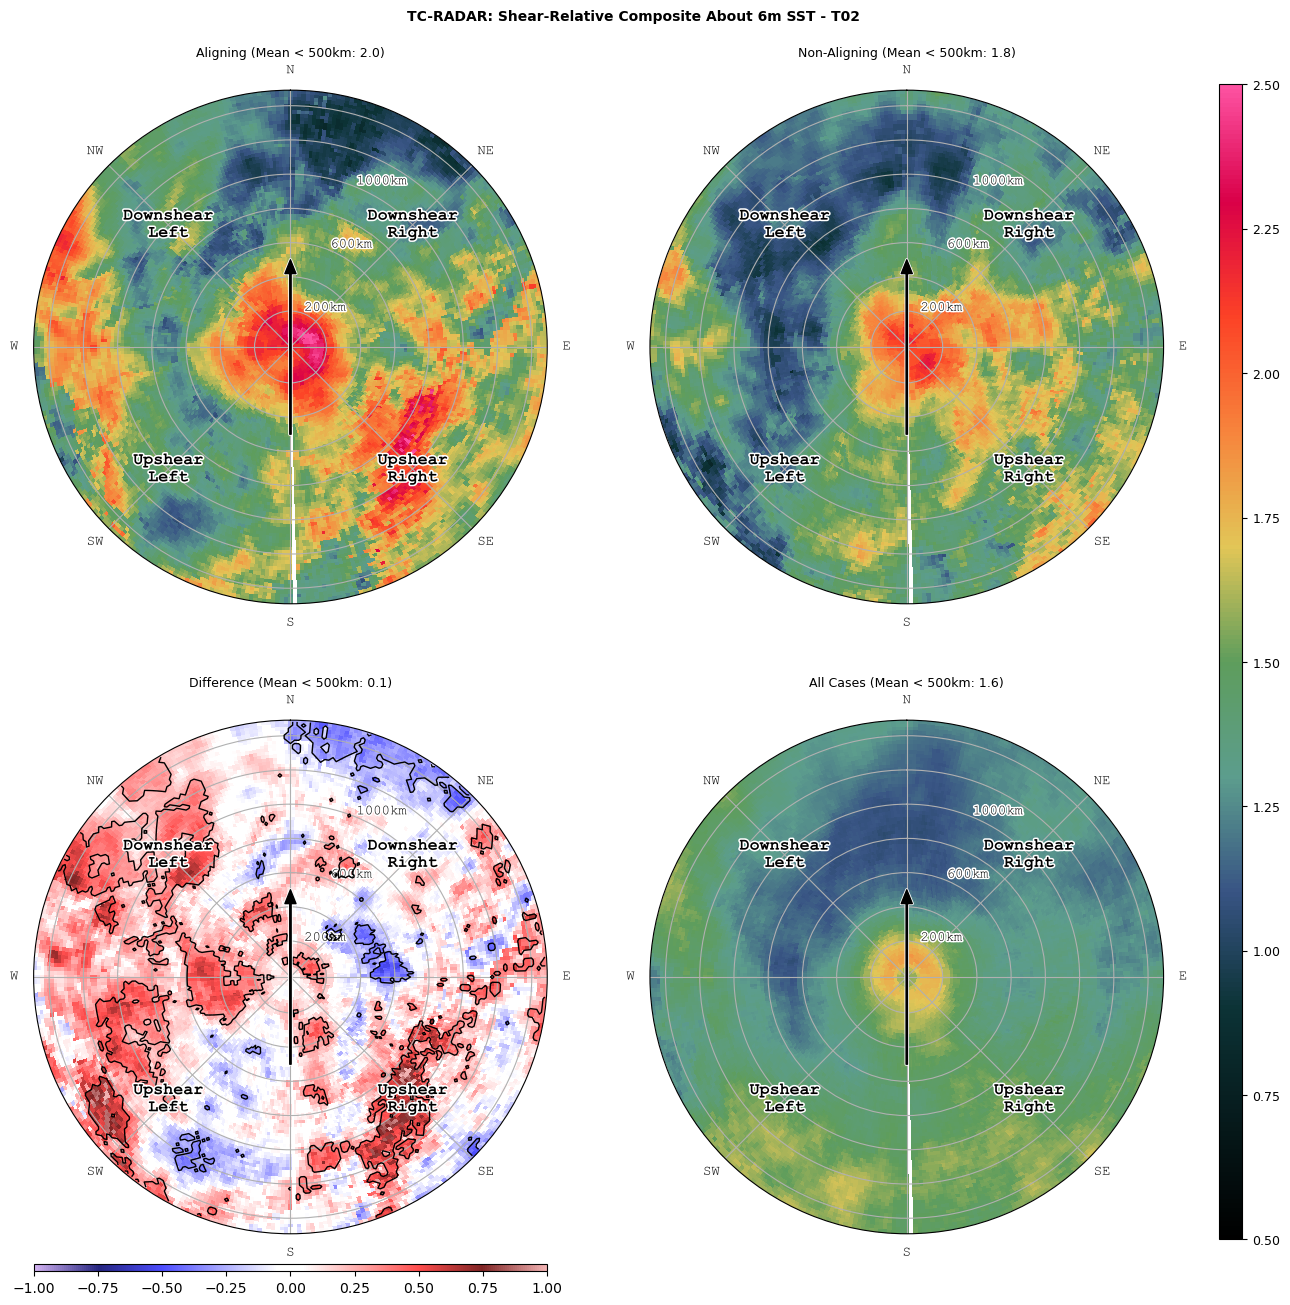

In [28]:
refl1 = rh[varShort].sel(case = alignment, r = slice(0, 1500)).mean('case')
refl2 = rh[varShort].sel(case = misalign, r = slice(0, 1500)).mean('case')
refl = rh[varShort].sel(r = slice(0, 1500)).mean('case')
data = refl1 - refl2
tstat, pval = ttest_ind(rh[varShort].sel(case = alignment, r = slice(0, 1500)), rh[varShort].sel(case = misalign, r = slice(0, 1500)), axis = 0, equal_var=False, nan_policy='omit')
sig_mask = pval < 0.05

fig, axes = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(18, 15))
axes[0, 0].pcolormesh(newTheta, refl1.r, refl1, cmap = cmap.probs4(), vmin = .5, vmax = 2.5)
labels(axes[0, 0])

c = axes[0, 1].pcolormesh(newTheta, refl2.r, refl2, cmap = cmap.probs4(), vmin = .5, vmax = 2.5)
labels(axes[0, 1])

ca = axes[1, 0].pcolormesh(newTheta, refl2.r, data, cmap = cmap.tempAnoms3(), vmin = -1, vmax = 1)
axes[1, 0].contour(newTheta, refl2.r, sig_mask, levels=[0.5], colors='black', linewidths=1)
labels(axes[1, 0])

c = axes[1, 1].pcolormesh(newTheta, refl.r, refl, cmap = cmap.probs4(), vmin = .5, vmax = 2.5)
labels(axes[1, 1])

cbar = fig.colorbar(c, ax=axes, orientation='vertical', aspect=50, pad=0.04)
cbar.ax.tick_params(axis='both', labelsize=9, left = False, bottom = False)

pos = axes[1, 0].get_position()

cbar_ax = fig.add_axes([
    pos.x0,            
    pos.y0 - 0.025,     
    pos.width,         
    0.005               
])

cbar = fig.colorbar(ca, cax=cbar_ax, orientation='horizontal')

fig.suptitle(f'TC-RADAR: Shear-Relative Composite {t}                               \n\n' , fontweight='bold', fontsize=10, y = 0.93)

axes[0, 0].set_title(f'Aligning (Mean < 500km: {str(round(np.nanmean(refl1.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[0, 1].set_title(f'Non-Aligning (Mean < 500km: {str(round(np.nanmean(refl2.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[1, 0].set_title(f'Difference (Mean < 500km: {str(round(np.nanmean(data.sel(r = slice(0, 500))), 1))})', fontsize=9)
axes[1, 1].set_title(f'All Cases (Mean < 500km: {str(round(np.nanmean(refl.sel(r = slice(0, 500))), 1))})', fontsize=9)

plt.savefig(r"C:\Users\deela\Downloads\tilt" + t + ".png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [ ]:
def rectangle(data):
    R, TH = np.meshgrid(data.r, newTheta, indexing='ij')

    xCoord = R * np.cos(TH)
    yCoord = R * np.sin(TH)

    points = np.column_stack([xCoord.ravel(), yCoord.ravel()])
    values = data.values.ravel()

    Rmax = float(data.r.max())
    # same resolution as your r-array, but centered
    x = np.linspace(-Rmax, Rmax, data.r.size)
    y = np.linspace(-Rmax, Rmax, data.r.size)
    Xt, Yt = np.meshgrid(x, y, indexing='xy')

    print(points.shape, values.shape, Xt.shape, Yt.shape)

    rhXY = scipy.interpolate.griddata(points, values, (Xt, Yt), method='linear')

    return Yt, Xt, rhXY

In [ ]:
# hgt = 850
# data = dataset['u_data']
# data = data.sel(level = hgt)
# ddir = dataset['shear_dir']
# u, newTheta = process(data, ddir)

# hgt = 850
# data = dataset['v_data']
# data = data.sel(level = hgt)
# ddir = dataset['shear_dir']
# v, newTheta = process(data, ddir)

# u1 = u[varShort].sel(case = alignment, r = slice(0, 1500)).mean('case')
# u2 = u[varShort].sel(case = misalign, r = slice(0, 1500)).mean('case')
# udat = u1 - u2

# v1 = v[varShort].sel(case = alignment, r = slice(0, 1500)).mean('case')
# v2 = v[varShort].sel(case = misalign, r = slice(0, 1500)).mean('case')
# vdat = v1 - v2

r1 = rh[varShort].sel(case = alignment, r = slice(0, 1500)).mean('case')
r2 = rh[varShort].sel(case = misalign, r = slice(0, 1500)).mean('case')
rdat = r1 - r2

X, Y, shum = rectangle(rdat)
# X, Y, uData = rectangle(udat)
# X, Y, vData = rectangle(vdat)


sY, sX = np.gradient(np.nan_to_num(shum, nan = 0.0), np.nan_to_num(Y[0, :], nan = 0.0), np.nan_to_num(X[:, 0], nan = 0.0))
grad = sX * uData + sY * vData

# Creates the plot
fig = plt.figure(figsize=(12, 10))
ax = plt.axes()
# ax.set_xlim(-1000, 1000)
# ax.set_ylim(-1000, 1000)
ax.set_ylabel('Meridional Distance (km)')
ax.set_xlabel('Zonal Distance (km)')
ax.grid()
ax.set_frame_on(False)

ax.set_title(f'TC-RADAR: Shear-Relative Composite Difference (Aligning - Non-Aligning)\n850mb Theta-E and Wind', fontweight='bold', fontsize=10, loc='left')
ax.set_title('Deelan Jariwala', fontsize=10, loc='right') 
# c = plt.contourf(X, Y, grad, shading='auto', cmap=cmap.tempAnoms3(), levels = np.arange(-0.10, 0.101, 0.001), extend = 'both')
c = plt.contourf(X, Y, shum, shading='auto', cmap=cmap.tempAnoms3(), levels = np.arange(-7.5, 7.6, 0.1), extend = 'both')
cb = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02)

plt.quiver(X[::2, ::2], Y[::2, ::2], uData[::2, ::2], vData[::2, ::2], pivot = 'middle', scale = 150, minshaft = 2, minlength=0, headaxislength = 3, headlength = 3, color = 'black')
plt.savefig(r"C:\Users\deela\Downloads\thetaEWind850.png", dpi = 400, bbox_inches = 'tight')
plt.show()